In [1]:
import os
import sys
from tqdm import tqdm,tnrange
import time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from music21 import *
from utilities.constants import *
from utilities.utilities import *

# Organise files in documents

In [2]:
pitchclass_df = get_pitchclassdistribution_df(SCORES_DIR)

In [3]:
pitchclass_df = pitchclass_df.transpose()
pitchclass_df.index = pitchclass_df.index.astype(int)
pitchclass_df = pitchclass_df.sort_index().transpose().replace(np.nan, 0)
pitchclass_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,13.230841,0.0,17.307244,0.0,11.413930,19.753086,0.000000,16.305614,0.0,14.232471,0.069881,7.686932
1,15.067751,0.0,12.899729,0.0,11.978320,19.566396,0.000000,9.918699,0.0,16.314363,14.254743,0.000000
2,17.145689,0.0,12.652792,0.0,20.515362,14.502808,0.000000,18.202841,0.0,11.529567,0.099108,5.351833
3,11.117371,0.0,14.741784,0.0,26.253521,15.906103,0.244131,16.244131,0.0,8.807512,0.807512,5.877934
4,12.091084,0.0,18.986530,0.0,22.482360,3.431687,5.291854,18.088518,0.0,15.651058,0.224503,3.752405


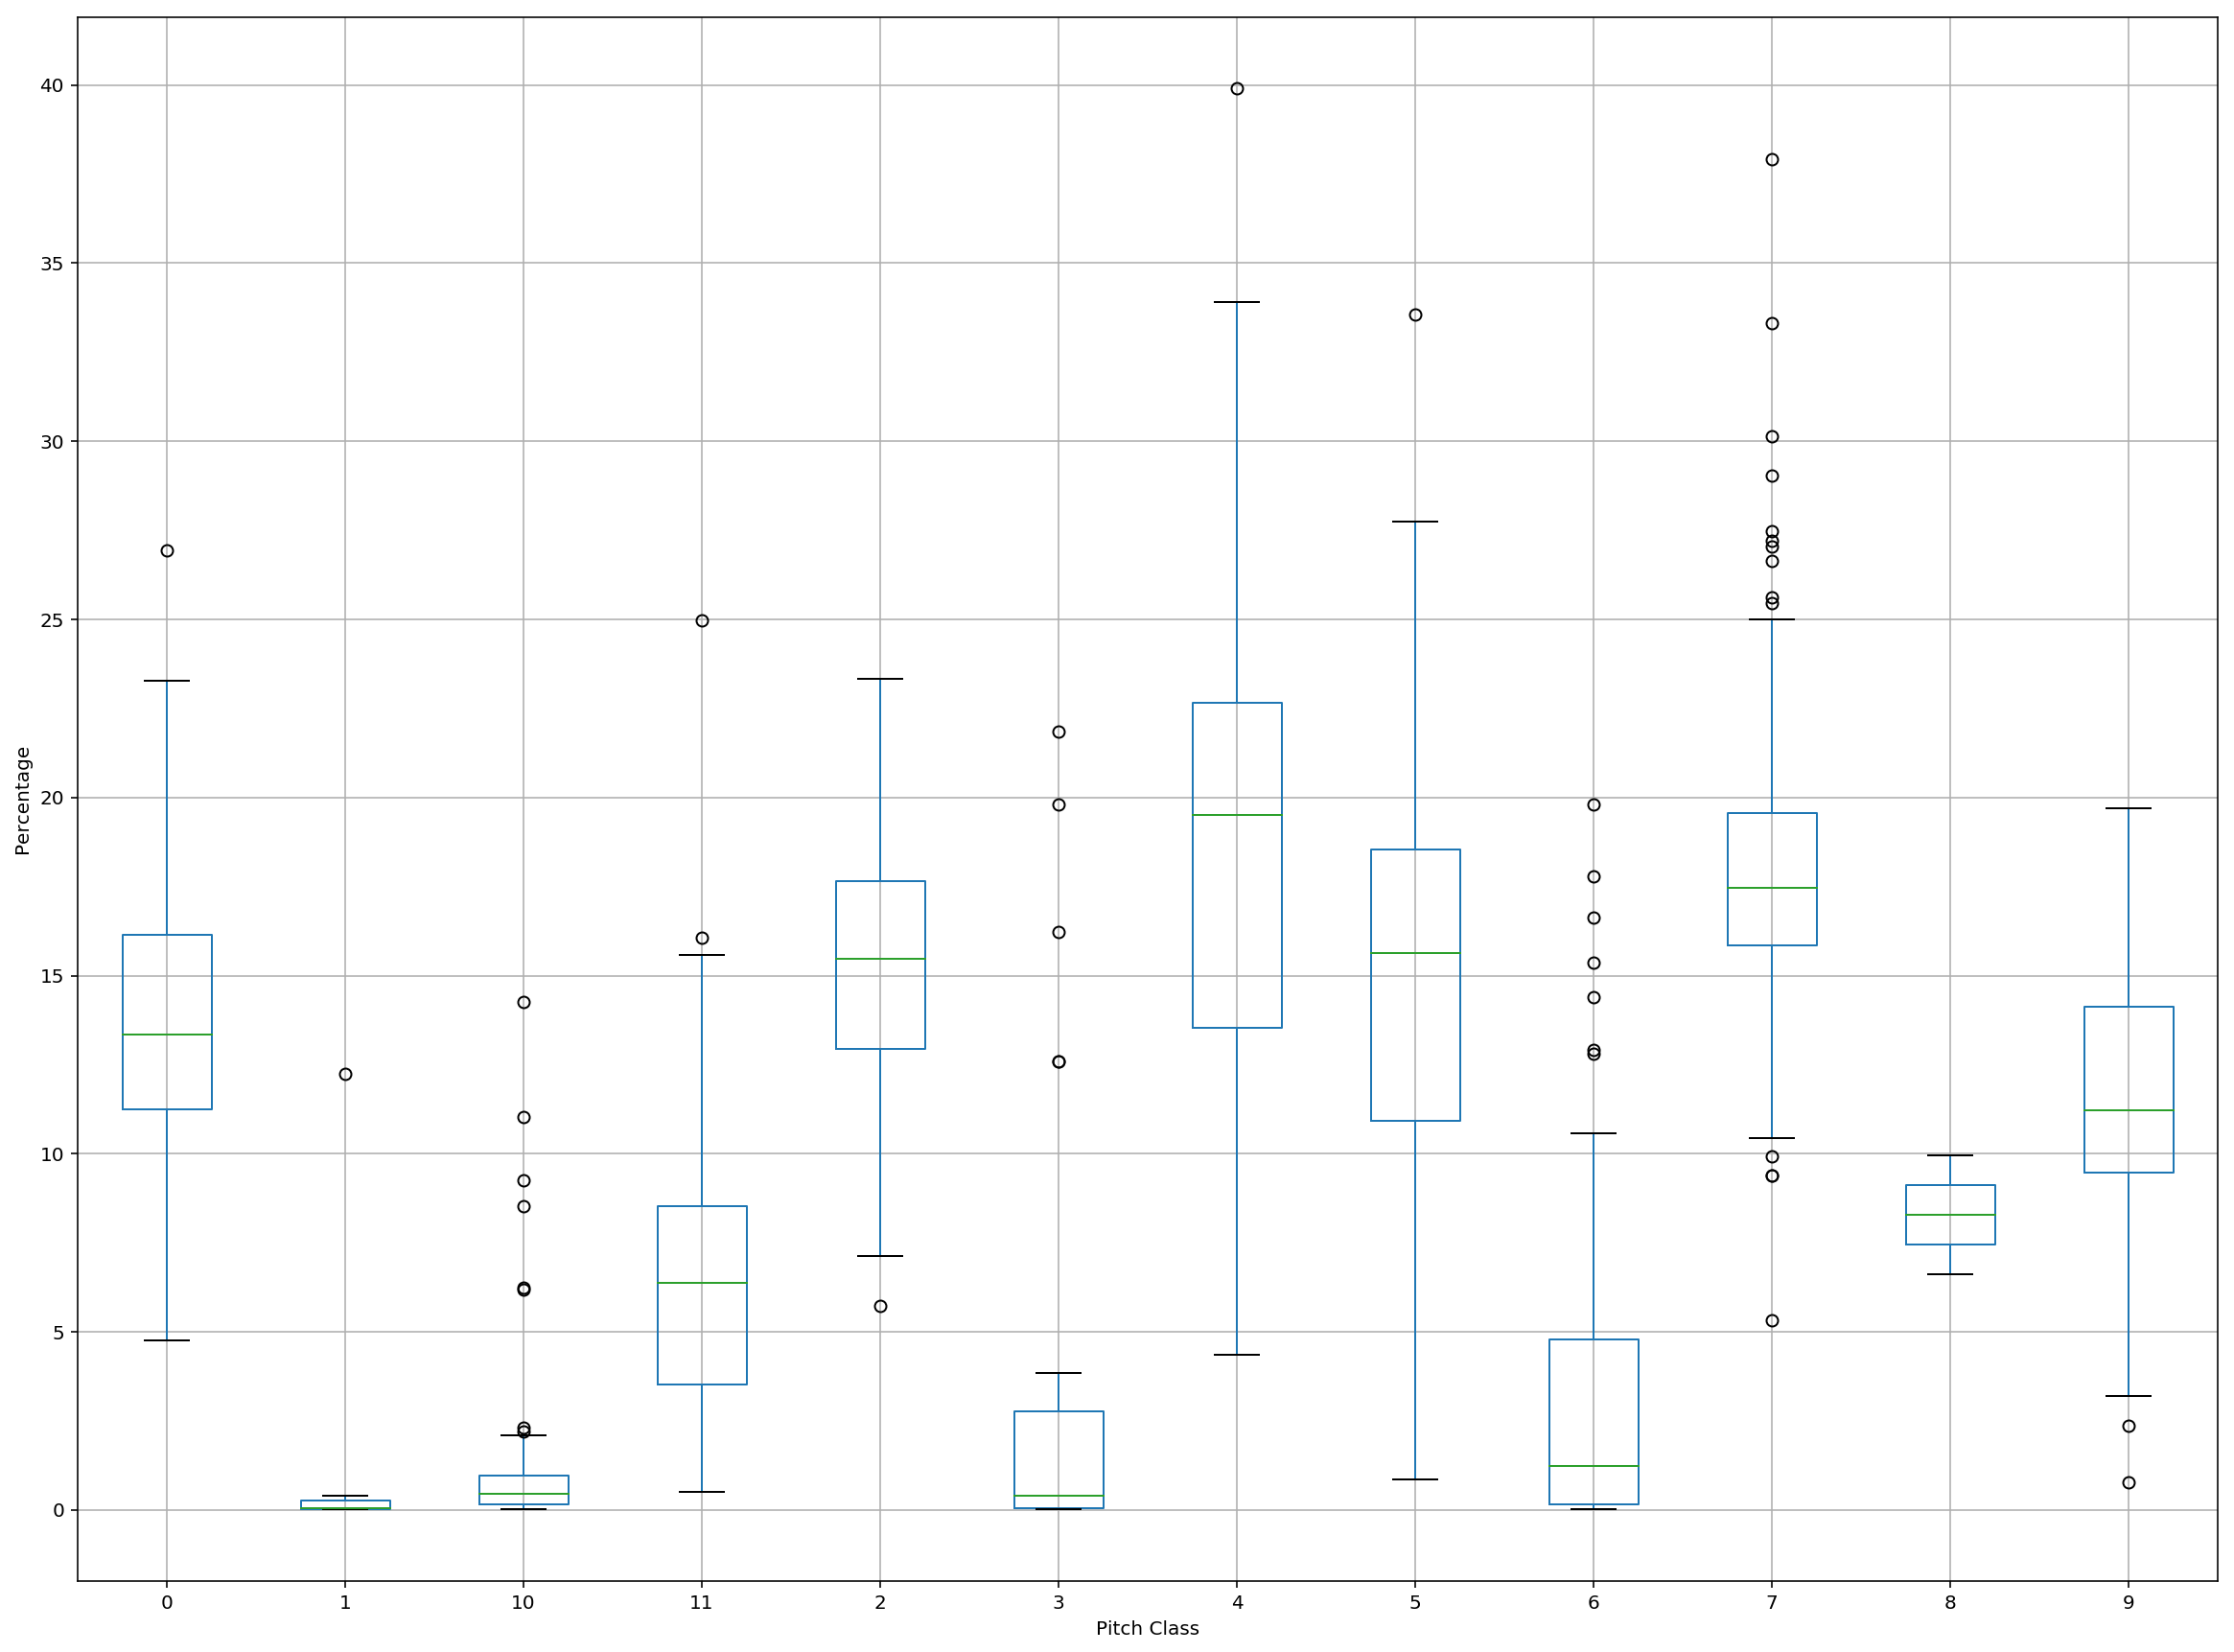

In [4]:
ax = pitchclass_df.boxplot(figsize = (20,15))
plt.xlabel("Pitch Class")
plt.ylabel("Percentage")
plt.savefig("test.png")

In [5]:
#print("{0}{1}{2}".format("Formatting files in ", SCORES_DIR, " and storing them in the scores folder..."))

#organize_xml_files(SCORES_DIR)

#print("Done")

In [6]:
#show_music21_settings()